<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/DGRNet%20STEP3-%20Hourly%20Data%20lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/500
543/543 [==============================] - 16s 21ms/step - loss: 0.9519 - mean_squared_error: 0.9519 - val_loss: 0.8827 - val_mean_squared_error: 0.8827
Epoch 2/500
543/543 [==============================] - 10s 19ms/step - loss: 0.8752 - mean_squared_error: 0.8752 - val_loss: 0.8843 - val_mean_squared_error: 0.8843
Epoch 3/500
543/543 [==============================] - 10s 18ms/step - loss: 0.8653 - mean_squared_error: 0.8653 - val_loss: 0.8739 - val_mean_squared_error: 0.8739
Epoch 4/500
543/543 [==============================] - 9s 17ms/step - loss: 0.8635 - mean_squared_error: 0.8635 - val_loss: 0.8673 - val_mean_squared_error: 0.8673
Epoch 5/500
543/543 [==============================] - 10s 18ms/step - loss: 0.8652 - mean_squared_error: 0.8652 - val_loss: 0.8645 - val_mean_squared_error: 0.8645
Epoch 6/500
543/543 [==============================] - 10s 18ms/step - loss: 0.8620 - mean_squared_error: 0.8620 - val_loss: 0.8666 - val_mean_squared_error: 0.8666
Epoch 7/500

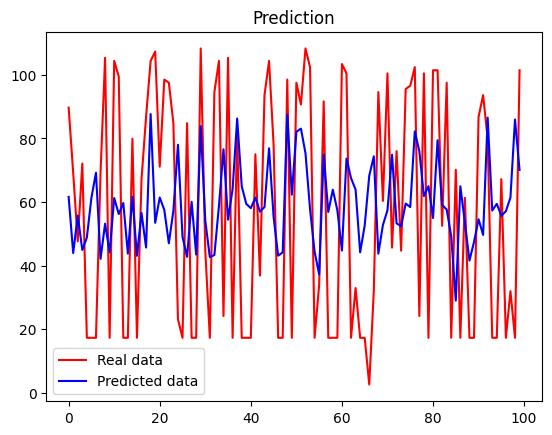

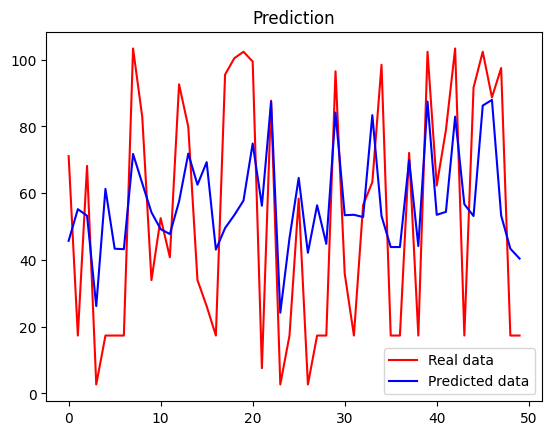

In [116]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from keras.callbacks import Callback
import plotly
import plotly.express as px # for data visualization
import seaborn as sns

generator_multiply = 1 #each input record will generate 100 random vectors from the latent space, given the mu and sigma generated by the encoder

#from keras.utils import plot_model
#import matplotlib.pyplot as plt

#window1 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-500.npy')
#window2 = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences_WINDOW-1000.npy')
#window = np.concatenate((window1, window2), axis=0)
#train_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TRAIN.npy')
#test_data = np.load(r'/content/drive/MyDrive/PHD/2021/multivariate_long_sequences-TEST.npy')



train_data = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences-TRAIN_hourly.npy') #------for Hourly data
index = 500
#We missed i=500 from processing the iosw. So here we are dropping row with index =500
train_data= np.delete(train_data, index, axis=0)


#test_data = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences-TEST_hourly.npy')
#all_data = np.concatenate((train_data,test_data),axis=0)
window_label = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences_WINDOW-TRAIN_hourly.npy')
n_seq = train_data.shape[0]
window_size = train_data.shape[1]
n_features = train_data.shape[2]


#---------------------------VAE ------------------------------------------
#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(train_data, window_label, test_size = 0.2, random_state = 42)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

encoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-encoder-saved-hourly-latent10-dim128-latest.model')
decoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-decoder-saved-hourly-latent10-dim128-latest.model')

X_train_encoded = encoder.predict(train_data)
mu, logvar, z = X_train_encoded
sigma = tf.exp(0.5 * logvar)
batch = tf.shape(mu)[0]  #number of recors / batchs
dim = tf.shape(mu)[1] #Ndimension of latent variable
store = list()
storetemp = list()


#For each batch, iterate, get the generator_multipy number of latent vectors with same window_size.
#For each z, concatenate z_mean, so it will become 100 dimensional vector

for i in range(0,batch):
  all_Z_i = tf.random.normal(shape=(generator_multiply,dim), mean = mu[i,:], stddev=sigma[i,:]) #all randorm vectors for this record i
  X_train_decoded = decoder.predict(all_Z_i)
  X_train_decoded = X_train_decoded.reshape((X_train_decoded.shape[0],window_size*n_features))
  a = np.arange(generator_multiply)
  a.fill(window_label[i])
  c=np.concatenate(((X_train_decoded,a[:,None])),axis=1)
  store.append(c)

results1=np.concatenate(store,axis=0)
results1=np.load(r'/content/drive/MyDrive/PHD/2024/labelled_subsquence_data_hourly.npy')
np.save(r'/content/drive/MyDrive/PHD/2024/labelled_subsquence_data_hourly',results1)


#Regression fitting
x=results1[:,:-1]
y=results1[:,window_size*n_features]


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#----- get a test set from this data, to avoid further wrangling----------------
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)


maxval = x.shape[0]
count_train = int(math.ceil(0.9*maxval))
x_train = x[:count_train]
x_test = x[count_train:]

y_train = y[:count_train]
y_test = y[count_train:]


from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.4)
yhat = iso.fit_predict(x_train)
# select all rows that are not outliers
mask = yhat != -1
x_train, y_train = x_train[mask, :], y_train[mask]

x_train = x_train.reshape((x_train.shape[0], window_size, n_features))  #DONT RUN IF MLP
x_test = x_test.reshape((x_test.shape[0], window_size, n_features))    #DONT RUN IF MLP


from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()

y_train_transformed = transformer.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_transformed = transformer.fit_transform(y_test.reshape(-1,1)).flatten()


from keras.layers import LeakyReLU

model = Sequential()
model.add(LSTM(256, input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units = 54))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(units = 32))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(units = 16))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(units = 1))

#sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizr = keras.optimizers.Adam(learning_rate=0.0001,clipnorm=1)
model.compile(loss='mean_squared_error', optimizer= optimizr, metrics=['mean_squared_error'])
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])


#reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
es = keras.callbacks.EarlyStopping(patience=20, verbose=1, min_delta=0.001, monitor='loss', mode='auto', restore_best_weights=True)
n_epochs = 500
#model.fit(x_train, y_train,epochs=5, batch_size=50, verbose=True)

#y_pred = model.predict(x_test)

#transform

#x_val = x_train[10001:13000]
#y_val = y_train_transformed[10001:13000]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train_transformed, test_size = 0.1, random_state = 42)

history=model.fit( x_train,y_train,
                 epochs=n_epochs,
                 batch_size=50,
                   #validation_data=(x_val,y_val),
                   validation_split=0.1,
                 callbacks=[es])

y_train_pred = model.predict(x_train)
y_train_pred = transformer.inverse_transform(y_train_pred)

y_pred = model.predict(x_test)
y_pred = transformer.inverse_transform(y_pred)

y_train = transformer.inverse_transform(y_train.reshape(-1,1)).flatten()
y_test = transformer.inverse_transform(y_test.reshape(-1,1)).flatten()



score_train= r2_score(y_train,y_train_pred)
print("r2 score is ==",score_train)

score= r2_score(y_test,y_pred)
print("r2 score is ==",score)


#plt.scatter(y_test,y_pred);
#plt.xlabel('Actual');
#plt.ylabel('Predicted');
plt.plot(y_train[0:100], color = 'red', label = 'Real data')
plt.plot(y_train_pred[0:100], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

#plt.scatter(y_test,y_pred);
#plt.xlabel('Actual');
#plt.ylabel('Predicted');
plt.plot(y_test[100:150], color = 'red', label = 'Real data')
plt.plot(y_pred[100:150], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()




np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/preduber_2.csv',y_pred)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/realuber_2.csv',y_test)
print("MAE is==",mean_absolute_error(y_test,y_pred))

#--------------------------------------Random Forest-------------------------------------------------------


###### Random forrest ergression
from sklearn.ensemble import RandomForestRegressor
 # create regressor object
regressor = RandomForestRegressor(n_estimators = 1000, random_state = 0)
# fit the regressor with x and y data
regressor.fit(x_train[0:10000],y_train_transformed[0:10000])


y_train_pred = regressor.predict(x_train[0:10000])
y_train_pred = y_train_pred.reshape(-1,1)
y_train_pred = transformer.inverse_transform(y_train_pred)

y_pred = regressor.predict(x_test[0:1000])
y_pred = y_pred.reshape(-1,1)
y_pred = transformer.inverse_transform(y_pred)


score_train= r2_score(y_train[0:10000],y_train_pred)
print("r2 score is ==",score_train)

score= r2_score(y_test[0:1000],y_pred)
print("r2 score is ==",score)


#plt.scatter(y_test,y_pred);
#plt.xlabel('Actual');
#plt.ylabel('Predicted');
plt.plot(y_train[0:1000], color = 'red', label = 'Real data')
plt.plot(y_train_pred[0:1000], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

#plt.scatter(y_test,y_pred);
#plt.xlabel('Actual');
#plt.ylabel('Predicted');
plt.plot(y_test[0:1000], color = 'red', label = 'Real data')
plt.plot(y_pred[0:1000], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()


sns.regplot(x=y_test[0:10],y=y_pred,ci=None,color ='red');

In [ ]:
from google.colab import drive
drive.mount('/content/drive')